In [24]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, types
from numba.typed import List
import numpy.random as npr

In [2]:
@jit(nopython=True)
def find_growth_candidates(domain):
    candidates = List()
    for i in range(1, domain.shape[0] - 1):
        for j in range(1, domain.shape[1] - 1):
            # Check only horizontal and vertical neighbors
            if domain[i, j] == 0 and (domain[i-1, j] == 1 or domain[i+1, j] == 1 or domain[i, j-1] == 1 or domain[i, j+1] == 1):
                candidates.append((i, j))
    return candidates

In [3]:
# SOR method to solve the Laplace equation
@jit(nopython=True)
def solve_laplace(concentration, domain, omega, epsilon):
    theta = np.float32(1e20)  
    iteration = 0  # Counter for iterations

    height, width = concentration.shape  
    while theta > epsilon:
        max_change = np.float32(0)
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                if domain[i, j] == 0:  # Update only if not part of the cluster
                    old_value = concentration[i, j]
                    # Compute the new concentration value
                    concentration[i, j] = (omega / 4) * (concentration[i+1, j] + concentration[i-1, j] + concentration[i, j+1] + concentration[i, j-1]) +  (1 - omega) * old_value
                    # Update the maximum change if necessary
                    max_change = max(max_change, np.abs(concentration[i, j] - old_value))
                else:
                    concentration[i, j] = 0  # Explicitly set concentration to zero if part of the cluster
                    
        iteration += 1

        # Update theta for the while-loop condition
        theta = max_change
    return concentration, iteration


In [4]:
# Growth function
# @jit(nopython=True)
def grow(domain, concentration, omega, eta, epsilon):
    concentration, iteration = solve_laplace(concentration, domain, omega, epsilon)
    candidates = find_growth_candidates(domain)
    if not candidates:
        return domain, concentration  # No more growth possible

    # Check if nutrient concentration exists
    has_nutrients = np.any(concentration[c[0], c[1]] > 0 for c in candidates)
    if not has_nutrients:
        return domain, concentration  # Stop growth due to lack of nutrients

    # Filter out candidates with zero concentration
    valid_candidates = [(i, j) for i, j in candidates if concentration[i, j] > 0]
    if not valid_candidates:
        return domain, concentration

    # Compute probabilities only for valid candidates
    probabilities = [concentration[i, j] ** eta if concentration[i, j] > 0 else 0 for i, j in valid_candidates]
    sum_probabilities = np.sum(probabilities)

    # Normalize the probabilities to ensure they sum to 1
    if sum_probabilities > 0:  # Prevent division by zero
        probabilities = [prob / sum_probabilities for prob in probabilities]
    else:  # In case all probabilities are zero, distribute chances equally among valid candidates
        probabilities = [1 / len(valid_candidates)] * len(valid_candidates)

    # Select and add new growth site
    index = np.random.choice(len(valid_candidates), p=probabilities)
    growth_site = valid_candidates[index]
    domain[growth_site] = 1
    return domain, concentration, iteration


In [5]:
# @jit(nopython=True)
def sim(domain, concentration, omega, iterations, eta, epsilon):
    iter_count = List()
    for _ in range(iterations):
        domain, concentration, count = grow(domain, concentration, omega, eta, epsilon)
        iter_count.append(count)
    return domain, concentration, iter_count

In [18]:
size = 100  # Size of the domain
seed_position = (size - 1, size // 2)  # Seed at the bottom center
iterations = 300  # Number of growth steps
omega = 1.85  # Over-relaxation parameter
epsilon = 1e-5  # epsilon for SOR convergence
eta = 2  # Shape parameter

# Initialize domain
domain = np.zeros((size, size), dtype=np.float32)  # Ensure dtype is specified
domain[seed_position] = 1  # Place the initial seed

# Initialize the nutrient concentration grid with highest concentration at the top
concentration = np.linspace(1, 0, size, dtype=np.float32).reshape(-1, 1)  # Ensure dtype is specified
concentration = np.tile(concentration, (1, size))  # Extend the gradient horizontally

domain, concentration, iter_count = sim(domain, concentration, omega, iterations, eta, epsilon)
print(f"Iterations: {np.mean(iter_count)}")

Iterations: 78.96333333333334


<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\sacha\AppData\Local\Temp\ipykernel_16352\4208609041.py:6: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'DLA Cluster with Nutrient Concentration \nGradient $\eta$ = {eta}')


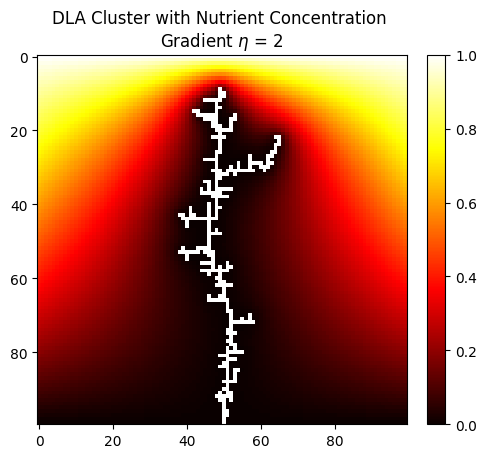

In [19]:
fig, ax = plt.subplots()
cmap = ax.imshow(concentration, cmap='hot', interpolation='nearest')
fig.colorbar(cmap, ax=ax, fraction=0.046, pad=0.04)
cluster_overlay = np.ma.masked_where(domain == 0, domain)
ax.imshow(cluster_overlay, cmap='Greys', interpolation='nearest')
ax.set_title(f'DLA Cluster with Nutrient Concentration \nGradient $\eta$ = {eta}')
plt.show()

<>:29: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\e'
C:\Users\sacha\AppData\Local\Temp\ipykernel_16632\3911085336.py:29: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel(f"$\eta$ = {eta}", fontsize=14)
C:\Users\sacha\AppData\Local\Temp\ipykernel_16632\3911085336.py:37: SyntaxWarning: invalid escape sequence '\e'
  fig.suptitle(f'DLA Cluster with a deviating Nutrient Concentration Gradient ($\eta$)', fontsize=16)


0.0 [1, 61, 49, 65, 1, 56, 54, 68, 66, 1, 55, 69, 1, 74, 39, 82, 41, 63, 46, 1, 61, 22, 1, 52, 59, 60, 27, 57, 1, 54, 32, 1, 24, 64, 1, 68, 7, 72, 57, 1, 35, 42, 64, 1, 55, 68, 53, 19, 65, 50, 40, 55, 71, 63, 27, 49, 1, 65, 62, 75, 33, 1, 64, 3, 1, 20, 25, 1, 62, 42, 69, 64, 44, 1, 55, 53, 67, 26, 23, 71, 36, 59, 51, 1, 35, 56, 29, 74, 1, 61, 1, 44, 67, 50, 55, 66, 72, 1, 47, 69, 66, 54, 1, 58, 34, 46, 1, 1, 53, 1, 67, 55, 70, 25, 66, 14, 21, 70, 1, 1, 56, 69, 1, 1, 82, 63, 89, 42, 33, 69, 1, 47, 30, 1, 47, 35, 55, 27, 65, 35, 37, 22, 44, 68, 1, 54, 15, 48, 4, 25, 52, 14, 1, 1, 67, 35, 1, 38, 1, 60, 1, 67, 1, 40, 22, 1, 13, 1, 63, 20, 68, 45, 53, 1, 44, 67, 1, 66, 71, 82, 28, 53, 52, 1, 30, 35, 1, 43, 36, 22, 36, 49, 1, 26, 27, 47, 1, 5, 8, 38, 1, 1, 55, 58, 24, 1, 40, 30, 54, 14, 1, 39, 1, 66, 42, 1, 72, 60, 1, 1, 22, 1, 1, 40, 55, 22, 1, 49, 1, 59, 69, 43, 25, 59, 26, 1, 44, 34, 50, 42, 1, 72, 25, 8, 31, 28, 31, 1, 59, 60, 18, 1, 64, 1, 52, 76, 1, 12, 21, 1, 48, 27, 56, 67, 67, 1, 53

C:\Users\sacha\AppData\Local\Temp\ipykernel_16632\3911085336.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


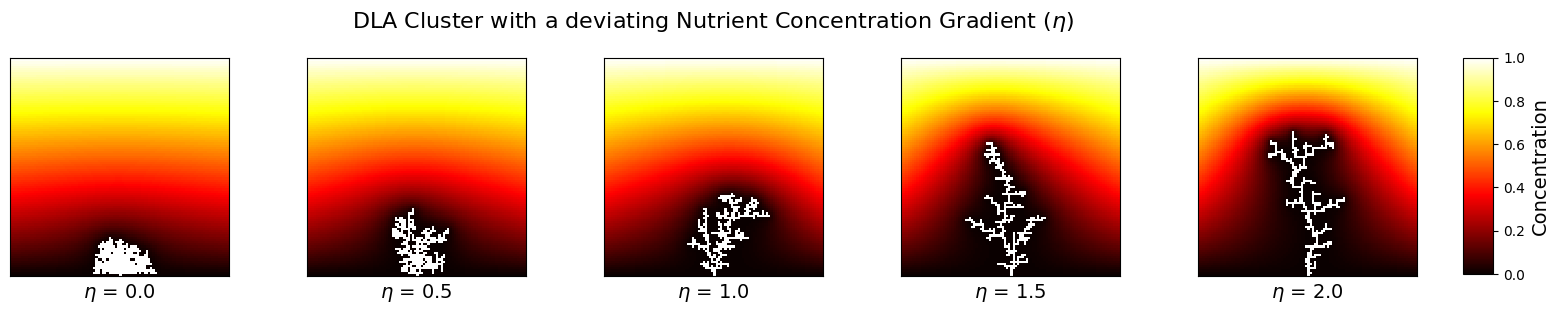

In [14]:
eta_list = np.linspace(0, 2, 5)

# Plotting
fig, axes = plt.subplots(1, len(eta_list), figsize=(15, 3))

for i, eta in enumerate(eta_list):
    # Parameters
    size = 100  # Size of the domain
    seed_position = (size - 1, size // 2)  # Seed at the bottom center
    iterations = 300  # Number of growth steps
    omega = 1.85  # Over-relaxation parameter
    epsilon = 1e-5  # epsilon for SOR convergence

    # Initialize domain
    domain = np.zeros((size, size))
    domain[seed_position] = 1  # Place the initial seed

    # Initialize the nutrient concentration grid with highest concentration at the top
    concentration = np.linspace(1, 0, size).reshape(-1, 1)  # Gradient from top (1) to bottom (0)
    concentration = np.tile(concentration, (1, size))  # Extend the gradient horizontally

    ax = axes[i]
    domain, concentration, count = sim(domain, concentration, omega, iterations, eta, epsilon)
    cmap = ax.imshow(concentration, cmap='hot', interpolation='nearest')
    cluster_overlay = np.ma.masked_where(domain == 0, domain)
    im = ax.imshow(cluster_overlay, cmap='Greys', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"$\eta$ = {eta}", fontsize=14)
    print(eta, count)

# Add colorbar
cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.72])  # [left, bottom, width, height]
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Concentration', fontsize=14)

fig.suptitle(f'DLA Cluster with a deviating Nutrient Concentration Gradient ($\eta$)', fontsize=16)

plt.tight_layout()
plt.show()


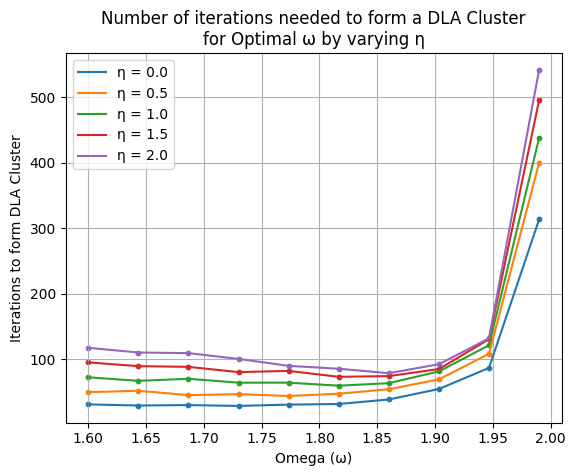

In [10]:
eta_list = np.linspace(0, 2, 5)
omega_list = np.linspace(1.6, 1.99, 10)

seed_position = (size - 1, size // 2)  # Seed at the bottom center
iterations = 300  # Number of growth steps
epsilon = 1e-5  # epsilon for SOR convergence
size = 100  # Size of the domain

# Store the final iteration count for each combination of eta and omega
result_iterations = np.zeros((len(eta_list), len(omega_list)))  # Prepare a matrix to hold the iteration counts

for eta_idx, eta in enumerate(eta_list):
    for omega_idx, omega in enumerate(omega_list):
        # Initialize domain and concentration
        domain = np.zeros((size, size))
        domain[seed_position] = 1  # Seed the initial particle
        concentration = np.linspace(1, 0, size).reshape(-1, 1)  # Nutrient concentration gradient
        concentration = np.tile(concentration, (1, size))

        # Run the simulation
        domain, concentration, count = sim(domain, concentration, omega, iterations, eta, epsilon)
        
        # Record the iteration count
        result_iterations[eta_idx, omega_idx] = np.mean(count)

# Now plot the results
for eta_idx, eta in enumerate(eta_list):
    plt.plot(omega_list, result_iterations[eta_idx, :], label=f'η = {eta}')
    plt.scatter(omega_list, result_iterations[eta_idx, :], s=10)  # Make scatter dots slightly larger for visibility

plt.legend()
plt.grid(True)
plt.xlabel('Omega (ω)')
plt.ylabel('Iterations to form DLA Cluster')
plt.title('Number of iterations needed to form a DLA Cluster\nfor Optimal ω by varying η')
plt.show()
plt.show()

In [25]:
@jit(nopython=True)
def monte_carlo(size, seed_position, num_walkers, ps=1):
    domain = np.zeros((size, size), dtype=np.int64)  # Use int64 to be explicit for numba
    domain[seed_position] = 1  # Start with a seed

    # Function for performing a single random walk
    def random_walk():
        # Start position for the walker at the top boundary
        x, y = 0, np.random.randint(size)

        # Perform the walk until the walker sticks or exits the domain
        while True:
            # Randomly select steps, avoiding diagonal by re-selecting if both non-zero
            while True:
                step_x = np.random.randint(-1, 2)
                step_y = np.random.randint(-1, 2)
                if not (step_x != 0 and step_y != 0):
                    break  # Break the loop if a valid movement is selected

            x, y = x + step_x, (y + step_y) % size  # Apply periodic boundary conditions horizontally

            # Check top and bottom boundaries
            if x < 0:
                x = 0  # Reset to top if it tries to move out from top
            elif x >= size:
                return -1, -1  # Indicate removal by returning a special value

            # Check if next to the cluster
            if (domain[max(0, x - 1), y] == 1 or
                domain[min(size - 1, x + 1), y] == 1 or
                domain[x, max(0, y - 1)] == 1 or
                domain[x, min(size - 1, y + 1)] == 1):
                if np.random.random() < ps:
                        return x, y  # Walker sticks


    # Main loop for DLA growth
    for _ in range(num_walkers):
        result = random_walk()
        if result != (-1, -1):  # Check if the walker should be added to the cluster
            domain[result] = 1  # Add new point to the cluster

    return domain


In [41]:
# Parameters
size = 100
seed_position = (size - 1, size // 2)  # Starting at the bottom center
num_walkers = 1200  # Number of walkers

# Run simulation
domain = monte_carlo(size, seed_position, num_walkers)

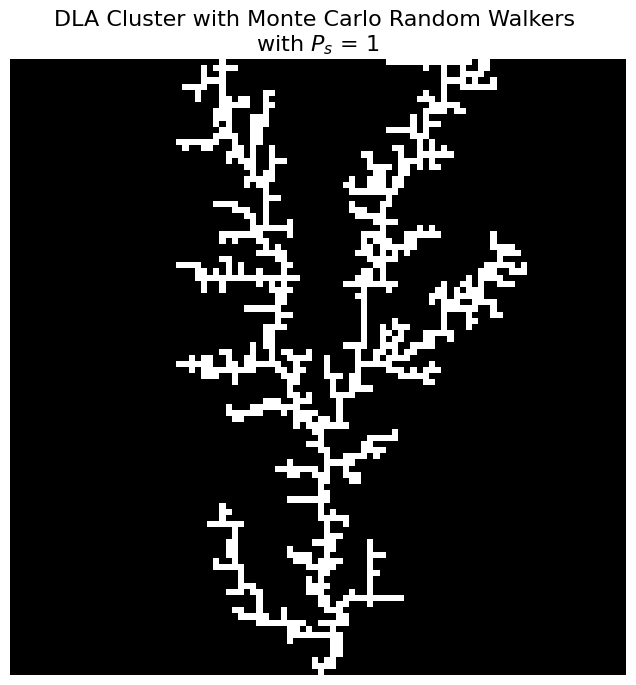

In [42]:
import matplotlib as mpl
# Custom color map: 0 for the background (red), 1 for the domain (yellow)
cmap = mpl.colors.ListedColormap(['black', 'white'])

# Ensure the domain values are exactly 0 or 1 for the custom colormap
domain_binary = np.where(domain > 0, 1, 0)  # Convert all non-zero values to 1

# Plot the result
plt.figure(figsize=(8, 8))
plt.imshow(domain_binary, cmap=cmap)  # Apply the custom color map here
plt.title('DLA Cluster with Monte Carlo Random Walkers \nwith $P_s$ = 1', fontsize=16, color='black')
plt.axis('off')  # Turn off the axis
plt.show()


In [34]:
# Parameters
size = 100
seed_position = (size - 1, size // 2)  # Starting at the bottom center
num_walkers = 1000  # Number of walkers
stick_probs = [0.1, 0.25, 0.5, 0.75, 1]  # Different sticking probabilities

results = []
for ps in stick_probs:
    # Run simulations
    domain = monte_carlo(size, seed_position, num_walkers, ps)
    results.append(domain)

print(len(results))

5


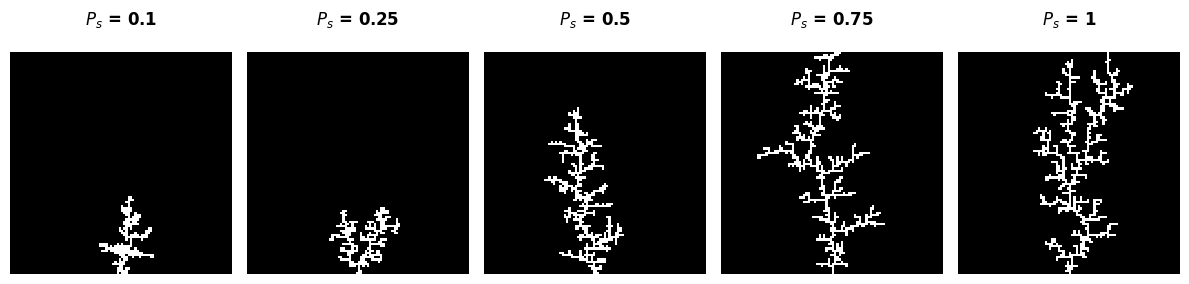

In [95]:
# Parameters for the visualization
fig, axes = plt.subplots(1, len(results), figsize=(12, 8))  # Adjust the figure size as needed

for ax, domain, ps in zip(axes, results, stick_probs):
    ax.imshow(domain, cmap='bone', interpolation='nearest')  # 'bone' colormap gives a nice contrast
    ax.set_title(f'$P_s$ = {ps}')
    ax.axis('off')  # Remove axis ticks and labels

plt.tight_layout()
plt.show()


In [136]:
def box_counting(img, sizes):
    counts = []  # To store the number of boxes needed for each size
    # Loop over each box size
    for size in sizes:
        count = 0
        # Cover the image with boxes of current size
        for x in range(0, img.shape[0], size):
            for y in range(0, img.shape[1], size):
                if np.any(img[x:x+size, y:y+size]):  # Check if the box contains part of the fractal
                    count += 1
        counts.append(count)

    return sizes, counts

In [137]:
def fractal_dimension(img, sizes):
    sizes, counts = box_counting(img, sizes)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]  # The fractal dimension is the negative of the slope

In [138]:
size = 100  # Size of the domain
seed_position = (size - 1, size // 2)  # Seed at the bottom center
iterations = 300  # Number of growth steps
omega = 1.85  # Over-relaxation parameter
epsilon = 1e-5  # epsilon for SOR convergence
eta = 1  # Shape parameter

num_walkers = 1000  # Number of walkers for the Monte Carlo method

# Initialize domain
domain = np.zeros((size, size), dtype=np.float32)  # Ensure dtype is specified
domain[seed_position] = 1  # Place the initial seed

# Initialize the nutrient concentration grid with highest concentration at the top
concentration = np.linspace(1, 0, size, dtype=np.float32).reshape(-1, 1)  # Ensure dtype is specified
concentration = np.tile(concentration, (1, size))  # Extend the gradient horizontally

In [139]:
n_runs = 10  # Number of runs to average over
res1 = np.zeros(n_runs)  # To store the fractal dimensions for DLA
res2 = np.zeros(n_runs)  # To store the fractal dimensions for Monte Carlo

# Parameters for the box sizes 
sizes = np.geomspace(1, 128, num=10, dtype=int)

for i in range(n_runs):
    domain, _, _ = sim(domain, concentration, omega, iterations, eta, epsilon)
    fd_v1 = fractal_dimension(domain, sizes)
    res1[i] = fd_v1

    domain_mc = monte_carlo(size, seed_position, num_walkers)
    fd_v2 = fractal_dimension(domain_mc, sizes)
    res2[i] = fd_v2

mean_fd_dla = np.mean(res1)
mean_fd_mc = np.mean(res2)

print(f'Mean Fractal dimension of DLA over {n_runs} runs: {mean_fd_dla}')
print(f'Fractal dimension of Monte Carlo over {n_runs}: {mean_fd_mc}')


Mean Fractal dimension of DLA over 10 runs: 1.469209310151757
Fractal dimension of Monte Carlo over 10: 1.336884788631616


In [157]:
n_runs = 10  # Number of runs to average over
stick_probs = np.linspace(0.1, 1, 10)  # Different sticking probabilities
res1 = np.zeros(n_runs)  # To store the fractal dimensions for DLA
res2 = np.zeros(n_runs)  # To store the fractal dimensions for Monte Carlo

# Parameters for the box sizes 
sizes = np.geomspace(1, 128, num=10, dtype=int)

results = []
for i in range(n_runs):
    run_results = []
    for ps in stick_probs:
        domain = monte_carlo(size, seed_position, num_walkers, ps)
        fd = fractal_dimension(domain, sizes)
        run_results.append(fd)
    results.append(run_results)

results_array = np.array(results)
mean_fractal_dimensions = np.mean(results_array, axis=0)

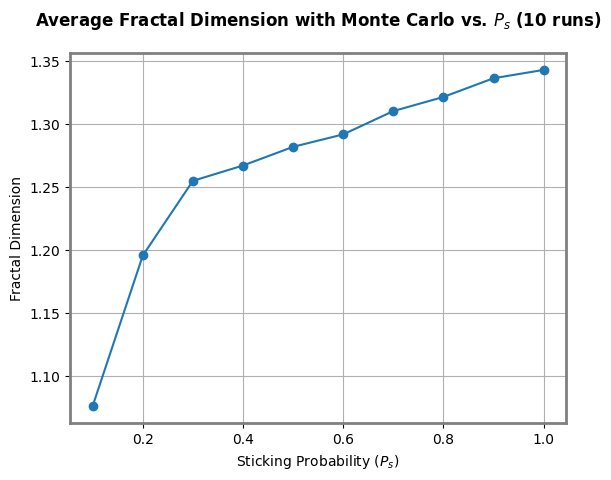

In [162]:
# Plot the results
plt.plot(stick_probs, mean_fractal_dimensions, marker='o')
plt.xlabel('Sticking Probability ($P_s$)')
plt.ylabel('Fractal Dimension')
plt.title(f'Average Fractal Dimension with Monte Carlo vs. $P_s$ ({n_runs} runs)')
plt.grid(True)
plt.show()

In [2]:
@jit(nopython=True)
def gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps):    
    # Stability condition check (for explicit scheme)
    assert (4 * D_u * dt) / (dx**2) <= 1, "The simulation might be unstable, adjust parameters."
    assert (4 * D_v * dt) / (dx**2) <= 1, "The simulation might be unstable, adjust parameters."

    # Initialize grid
    u = np.zeros((grid_size, grid_size))
    v = np.zeros((grid_size, grid_size))

    # For the initial conditions, you can take u = 0.5 everywhere in the system
    u[:, :] = 0.5
    
    # take v = 0.25 in a small square in the center of the system, and 0 outside.
    v[grid_size//4:3*grid_size//4, grid_size//4:3*grid_size//4] = 0.25
    # v[grid_size//2-5:grid_size//2+5, grid_size//2-5:grid_size//2+5] = 0.25

    # add small amount of noise to the system
    v += np.random.normal(0, 0.05, (grid_size, grid_size))
    u += np.random.normal(0, 0.05, (grid_size, grid_size))

    # Diffusion simulation
    for step in range(steps):
        u_old = u.copy()
        for i in range(1, grid_size-1):
            for j in range(1, grid_size-1):
                laplacian_u = (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - 4 * u[i, j]) / dx**2
                laplacian_v = (v[i+1, j] + v[i-1, j] + v[i, j+1] + v[i, j-1] - 4 * v[i, j]) / dx**2
                reaction = u[i, j] * v[i, j]**2
                u[i, j] += D_u * dt * laplacian_u - reaction + f * (1 - u[i, j])
                v[i, j] += D_v * dt * laplacian_v + reaction - (f + k) * v[i, j]
    
        if np.max(np.abs(u - u_old)) < 1e-5:
            convergence = True
        else:
            convergence = False

        # Periodic boundary condition
        u[:, -1] = u[:, 0]
        u[-1, :] = u[0, :]
        v[:, -1] = v[:, 0]
        v[-1, :] = v[0, :]
    # print(convergence)
        
    return u, v, convergence

False


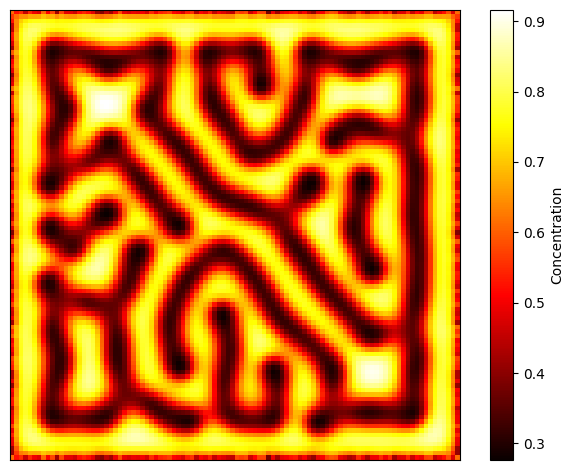

In [15]:
# Parameters
grid_size = 100
dt = 1  # Time step, arbitrary units
dx = 1  # Grid spacing, arbitrary units
D_u = 0.16  # Diffusion coefficient, arbitrary units
D_v = 0.08  # Diffusion coefficient, arbitrary units
f = 0.035  # Feed rate, arbitrary units
k = 0.06  # Kill rate, arbitrary units
steps = 2000 # Number of time steps to simulate

u, v, conv = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)
plt.imshow(u, cmap='hot', interpolation='nearest')
print(conv)

plt.xlabel(f"t = {np.round(dt)}")
plt.colorbar(label='Concentration')

#hide axis
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# plt.title(f'Concentration After {steps} Steps and time = {1} \n (Y-axis diffusion only)')
plt.tight_layout()
plt.show()

False


C:\Users\sacha\AppData\Local\Temp\ipykernel_20092\3542705518.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


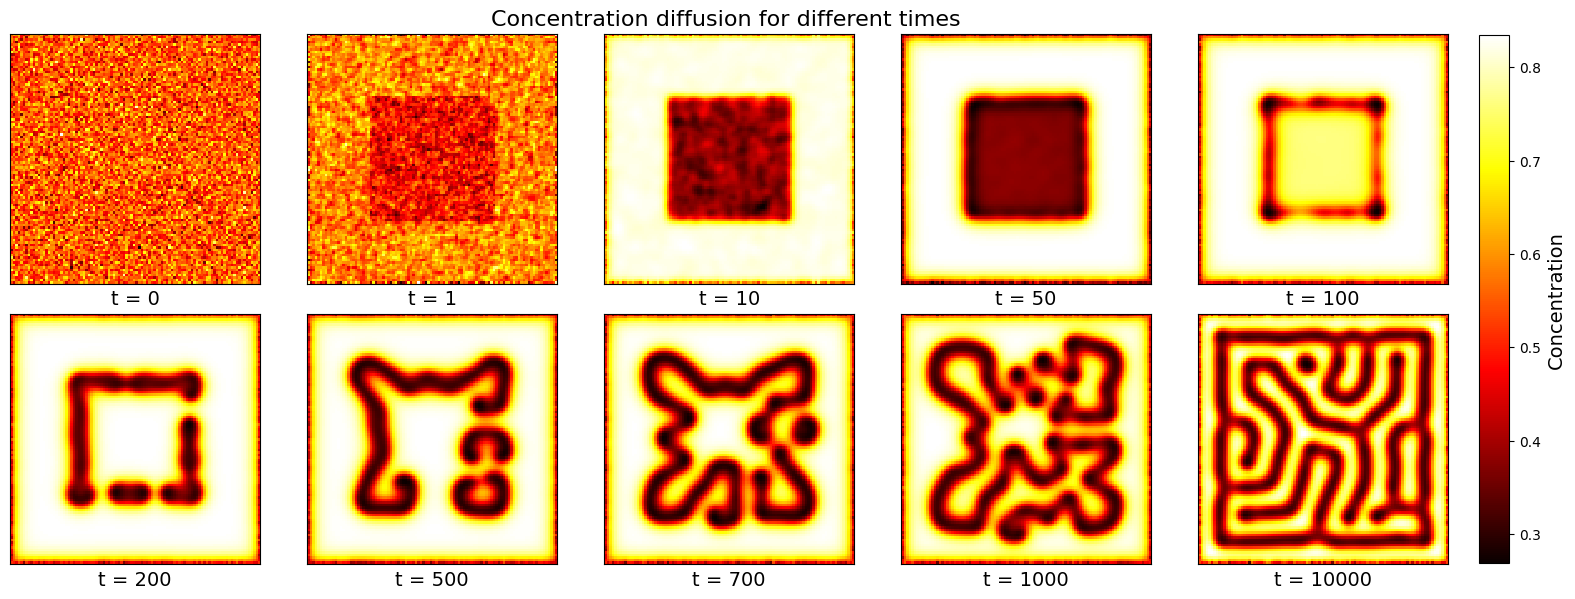

In [22]:
def plot_concentration_over_time(grid_size, D_u, D_v, f, k, dt, dx, steps_list, title_suffix=''):
    num_rows = 2  # Number of rows
    num_cols = len(steps_list) // num_rows  # Number of columns

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    for i, steps in enumerate(steps_list):
        row_idx = i // num_cols
        col_idx = i % num_cols

        u, v, conv = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)
        ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
        im = ax.imshow(u, cmap='hot', interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(f"t = {steps}", fontsize=14)
    print(conv)

    # Add colorbar
    cbar_ax = fig.add_axes([1, 0.06, 0.02, 0.88])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Concentration', fontsize=14)

    # Set title for the last subplot
    axes[0, 2].set_title(f'Gray- Scott Concentration diffusion for different times {title_suffix}', fontsize=16, loc='center')

    plt.tight_layout()
    plt.show()

# Parameters
grid_size = 100
dt = 1  # Time step, arbitrary units
dx = 1  # Grid spacing, arbitrary units
D_u = 0.16  # Diffusion coefficient, arbitrary units
D_v = 0.08  # Diffusion coefficient, arbitrary units
f = 0.035  # Feed rate, arbitrary units
k = 0.060  # Kill rate, arbitrary units

# Plot concentration over time for different steps_list
steps_list_1 = [0, 1, 10, 50, 100, 200, 500, 700, 1000, 10000]

plot_concentration_over_time(grid_size, D_u, D_v, f, k, dt, dx, steps_list_1)


C:\Users\sacha\AppData\Local\Temp\ipykernel_20092\3713156401.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


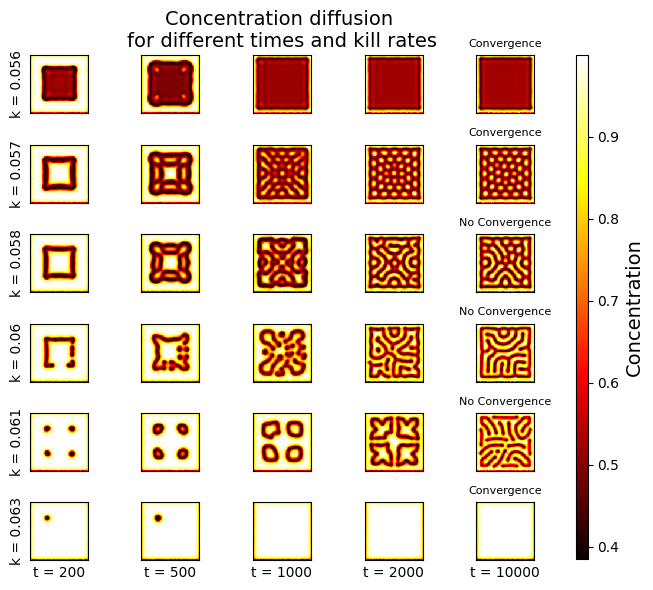

In [39]:
def plot_k_diff_over_time(grid_size, D_u, D_v, f, k_list, dt, dx, steps_list):

    fig, axes = plt.subplots(len(k_list), len(steps_list), figsize=(6, 6))
    # plt.ylabel('Kill rate', fontsize=14)

    for i, steps in enumerate(steps_list):
        for j, k in enumerate(k_list):
            u, v, conv = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)
            ax = axes[j, i]
            im = ax.imshow(u, cmap='hot', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
            axes[j,0].set_ylabel(f"k = {k}", fontsize=10)
            if conv == True:
                axes[j,-1].set_title(f"Convergence", fontsize=8)
            else:
                axes[j,-1].set_title(f"No Convergence", fontsize=8)
        ax.set_xlabel(f"t = {steps}", fontsize=10)
    axes[0, 2].set_title(f'Concentration diffusion \nfor different times and kill rates', fontsize=14, loc='center')

    # Add colorbar
    cbar_ax = fig.add_axes([1, 0.06, 0.02, 0.84])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Concentration', fontsize=14)

    # plt.title(f'Concentration diffusion \nfor different times and kill rates', fontsize=14, loc='center')

    plt.tight_layout()
    plt.show()

# Parameters
grid_size = 100
dt = 1  # Time step, arbitrary units
dx = 1  # Grid spacing, arbitrary units
D_u = 0.16  # Diffusion coefficient, arbitrary units
D_v = 0.08  # Diffusion coefficient, arbitrary units
f = 0.035  # Feed rate, arbitrary units
k_list = [0.056, 0.057, 0.058, 0.060, 0.061, 0.063]  # Kill rate, arbitrary units
steps_list = [200, 500, 1000, 2000, 10000]  # Number of time steps to simulate

# Plot concentration over time for different kill rates
plot_k_diff_over_time(grid_size, D_u, D_v, f, k_list, dt, dx, steps_list)


C:\Users\sacha\AppData\Local\Temp\ipykernel_20092\4287409500.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


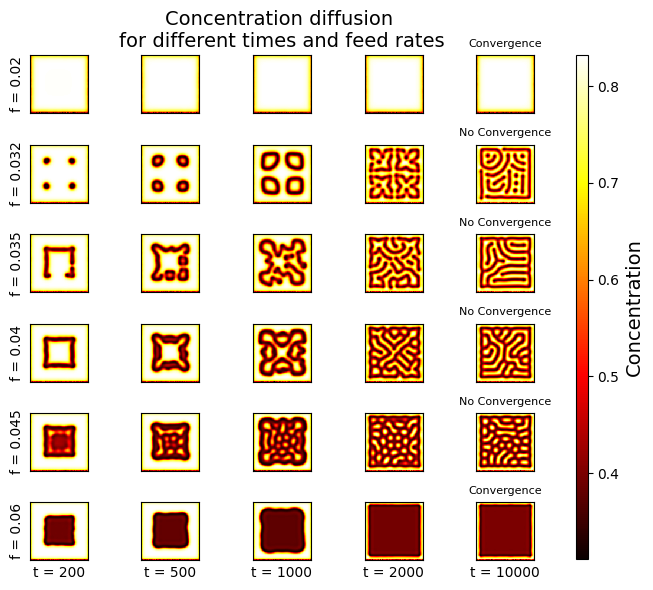

In [40]:
def plot_f_diff_over_time(grid_size, D_u, D_v, f_list, k, dt, dx, steps_list):

    fig, axes = plt.subplots(len(f_list), len(steps_list), figsize=(6, 6))
    # plt.ylabel('Kill rate', fontsize=14)

    for i, steps in enumerate(steps_list):
        for j, f in enumerate(f_list):
            u, v, conv = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)
            ax = axes[j, i]
            im = ax.imshow(u, cmap='hot', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
            # ax.set_xlabel(f"t = {steps}", fontsize=14)
            axes[j,0].set_ylabel(f"f = {f}", fontsize=10)
            if conv == True:
                axes[j,-1].set_title(f"Convergence", fontsize=8)
            else:
                axes[j,-1].set_title(f"No Convergence", fontsize=8)
        ax.set_xlabel(f"t = {steps}", fontsize=10)
    axes[0, 2].set_title(f'Concentration diffusion \nfor different times and feed rates', fontsize=14, loc='center')        

    # Add colorbar
    cbar_ax = fig.add_axes([1, 0.06, 0.02, 0.84])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Concentration', fontsize=14)

    plt.tight_layout()
    plt.show()

# Parameters
grid_size = 100
dt = 1  # Time step, arbitrary units
dx = 1  # Grid spacing, arbitrary units
D_u = 0.16  # Diffusion coefficient, arbitrary units
D_v = 0.08  # Diffusion coefficient, arbitrary units
k = 0.060  # Feed rate, arbitrary units
f_list = [0.02, 0.032, 0.035, 0.04, 0.045, 0.06]  # Kill rate, arbitrary units
steps_list = [200, 500, 1000, 2000, 10000]  # Number of time steps to simulate

# Plot concentration over time for different kill rates
plot_f_diff_over_time(grid_size, D_u, D_v, f_list, k, dt, dx, steps_list)


In [4]:
from scipy.ndimage import label

@jit(nopython=True)
def phase_diagram(grid_size, D_u, D_v, f_range, k_range, dt, dx, steps):
    # Initialize arrays to store phase information
    phases = np.zeros((len(f_range), len(k_range)))

    # Simulate Gray-Scott model for each parameter combination
    for i, f in enumerate(f_range):
        for j, k in enumerate(k_range):
            # Simulate Gray-Scott model
            u, v = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)

            # Label connected regions
            # v neemt over
            if np.mean(u) <= 0.5 and np.mean(u) < np.mean(v):
                phase_label = 0
            # u neemt over
            elif np.mean(u) >= 0.9 and np.mean(u) > np.mean(v):
                phase_label = 2
            else:
                phase_label = 1

            # # Assign phase label based on the number of features
            # # Example: if multiple features are observed, assign phase label 1 (spots)
            # # Example: if a single feature is observed, assign phase label 2 (stripes)
            # if num_features > 1:
            #     phase_label = 1  # u
            # else:
            #     phase_label = 2  # v

            # Store phase label in phases array
            phases[i, j] = phase_label
    return phases

# Parameters
grid_size = 100
dt = 1  # Time step
dx = 1  # Space step
D_u = 0.16  # Diffusion coefficient for U
D_v = 0.08  # Diffusion coefficient for V
steps = 2000  # Number of time steps

# Define parameter ranges
f_range = np.linspace(0, 0.3, 100)
k_range = np.linspace(0, 0.08, 100)


phases = phase_diagram(grid_size, D_u, D_v, f_range, k_range, dt, dx, steps)
# Plot phase diagram
plt.imshow(phases, extent=[k_range[0], k_range[-1], f_range[0], f_range[-1]], aspect='auto', cmap='viridis', interpolation='nearest')
# plt.colorbar(label='Phase')
plt.xlabel('k')
plt.ylabel('f')
plt.title('Phase Diagram of Gray-Scott Model')
plt.show()

In [3]:
@jit(nopython=True)
def phase_diagram(grid_size, D_u, D_v, f_range, k_range, dt, dx, steps):
    # Initialize arrays to store phase information
    phases = np.zeros((len(f_range), len(k_range)))

    # Simulate Gray-Scott model for each parameter combination
    for i, f in enumerate(f_range):
        for j, k in enumerate(k_range):
            # Simulate Gray-Scott model
            u, v, conv = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)

            if conv == True:
                # Check which species dominates
                if np.mean(u) > np.mean(v):
                    phase_label = 1  # u dominates
                else:
                    phase_label = 2  # v dominates
            else:
                phase_label = 1.5  # No convergence

            # Store phase label in phases array
            phases[i, j] = phase_label
        print(i)
    return phases

# Parameters
grid_size = 100
dt = 1  # Time step
dx = 1  # Space step
D_u = 0.16  # Diffusion coefficient for U
D_v = 0.08  # Diffusion coefficient for V
steps = 2000  # Number of time steps

# Define parameter ranges
f_range = np.linspace(0, 0.3, 100)
k_range = np.linspace(0, 0.08, 100)

# Generate phase diagram
phases = phase_diagram(grid_size, D_u, D_v, f_range, k_range, dt, dx, steps)

# Plot phase diagram
plt.imshow(phases, extent=[k_range[0], k_range[-1], f_range[0], f_range[-1]], aspect='auto', cmap='viridis')
plt.colorbar(label='Dominant Species')
plt.xlabel('k')
plt.ylabel('f')
plt.title('Phase Diagram of Gray-Scott Model')
plt.show()


0
1
